# The Battle of Neighborhoods
## Report
## 1. Business problem
Couple of old friends decided to make a longtime dream come true. They want to open a craft beer **bar** in Vilnius, Lithuania.  
And for that they need the right spot. 

Property experts say that the **three most important factors** in determining the desirability of a property are:
1. Location
2. Location
3. Location

So I have to choose which location fits thir business and their goals.

<tr>
    <td> <img src="img/bar.gif" alt="Drawing" style="height: 220px; width: 220px;"/> </td>
    <td> <img src="img/ofcourse.gif" alt="Drawing" style="height: 220px; width: 220px;"/> </td>
</tr>

## 2. Data
### Data requirements
After doing some research and reading some articles on how to choose perfect location for a bar (ex. <a src="https://www.dummies.com/business/start-a-business/how-to-find-your-bars-ideal-location/">How to Find Your Bar’s Ideal Location</a>) I decided to use this data:
- List of Vilnius neighborhoods 
- List of all Vilnius beer bars and stores
- List of places to avoid (ex. adult stores, pawn shops, police stations)
- List of places that is nice to have nearby (ex. parkings, public transport, taxi standings)

### Data sources

- <a src="https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius">Neighborhoods of Vilnius</a>
- <a src="https://developer.foursquare.com/docs/places-api/">Foursquare Places API</a>

## 3. Data analysis

In [506]:
import foursquare
import pandas as pd
import numpy as np
import folium
import string
import requests
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [360]:
url = 'https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius'
df = pd.read_html(url, attrs={'class': 'wikitable'})[0]

In [361]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={'Neighborhoods': 'Neighborhood', 
           'Area (km2)[1]': 'Area', 
           'Pop. (2001)[1]': 'Population', 
           'Density (2001)[1]': 'Density'}, inplace=True)

In [362]:
dictionary = {'š': 's', 'ė': 'e', 'č': 'c', 'ž': 'z', 'ū': 'u'}

def replace_letters(st):
    for old, new in dictionary.items():
        st = st.lower().replace(old, new)
    return string.capwords(st)

In [363]:
df['Neighborhood'] = df['Neighborhood'].apply(replace_letters)

In [409]:
df.head()

,Neighborhood,Area,Population,Density,Latitude,Longitude
0,Verkiai,56.0,30856,551.0,54.708707,25.284686
1,Antakalnis,77.2,39697,514.2,54.701126,25.308957
2,Pasilaiciai,7.9,25674,3249.9,54.725942,25.231328
3,Fabijoniskes,5.9,36644,6210.8,54.723397,25.249529
4,Pilaite,13.9,15996,1150.8,54.708126,25.175803


### Vilnius neighborhoods map

In [503]:
VILNIUS_LOCATION = [54.683333, 25.283333]

In [504]:
mmap = folium.Map(location=VILNIUS_LOCATION, zoom_start=11)
for (name, lat, lng) in zip(df['Neighborhood'], df['Latitude'], df['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        color='blue',
        fill = True,
        popup=name,
        fill_color='blue'
    ).add_to(mmap)
mmap

In [190]:
CLIENT_ID = '***' # your Foursquare ID
CLIENT_SECRET = '***' # your Foursquare Secret

In [24]:
client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

In [425]:
def getNearbyVenues(names, latitudes, longitudes, areas, categories, radius=100, limit=100):
    
    venues_list=[]
    for name, lat, lng, area in zip(names, latitudes, longitudes, areas):
        rad = radius*np.sqrt(area)
         
        for cat in categories:
            results = client.venues.explore(
                params={'ll': '{}, {}'.format(lat, lng), 'radius': rad, 
                        'limit': limit, 'categoryId': cat})['groups'][0]['items']

            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'] if v['venue']['categories'] else np.nan) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return nearby_venues

###  Getting beer bars and stores locations

In [432]:
bar_categories = ['5370f356bcbc57f1066c94c2', '56aa371ce4b08b9a8d57356c', '4bf58dd8d48988d11b941735']
bars = getNearbyVenues(names=df['Neighborhood'],
                         latitudes=df['Latitude'],
                         longitudes=df['Longitude'], areas=df['Area'], categories=bar_categories)

In [433]:
bars.drop_duplicates(inplace=True)
bars.reset_index(drop=True, inplace=True)
bars['Venue Category'] = 'Bar'

In [434]:
bars.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Verkiai,54.708707,25.284686,Alynas Beershop,54.709580,25.292089,Bar
1,Verkiai,54.708707,25.284686,Vilniaus Alus,54.702570,25.288155,Bar
2,Verkiai,54.708707,25.284686,Alaus studija,54.707954,25.295803,Bar
3,Verkiai,54.708707,25.284686,Alaus studija,54.707954,25.295803,Bar
4,Verkiai,54.708707,25.284686,"Restoranas ""Fortas""",54.708429,25.290552,Bar


In [406]:
bars.groupby('Neighborhood')['Neighborhood'].count().to_frame()

,Neighborhood
Neighborhood,
Karoliniskes,1
Naujamiestis,5
Rasos,22
Senamiestis,5
Verkiai,7


### Getting parkings locations

In [521]:
parking_categories = ['4c38df4de52ce0d596b336e1', '4bf58dd8d48988d1fd941735']
parkings = getNearbyVenues(names=df['Neighborhood'],
                         latitudes=df['Latitude'],
                         longitudes=df['Longitude'], areas=df['Area'], categories=parking_categories, radius=150)

In [418]:
parkings.drop_duplicates(inplace=True)
parkings.reset_index(drop=True, inplace=True)
parkings['Venue Category'] = 'Parking'

### Getting 'bad neighbors'
As 'bad neighbors' I'm going to use police stations, schools, churches, adult stores, etc.

In [ ]:
bad_venues_categories = ['4bf58dd8d48988d12e941735', '4f4533804b9074f6e4fb0105', 
                         '5267e446e4b0ec79466e48c4', '52f2ab2ebcbc57f1066b8b32', 
                         '4f4533814b9074f6e4fb0106', '4bf58dd8d48988d131941735',
                         '4d954b06a243a5684965b473', '52f2ab2ebcbc57f1066b8b34']
bad_venues = getNearbyVenues(names=df['Neighborhood'],
                         latitudes=df['Latitude'],
                         longitudes=df['Longitude'], areas=df['Area'], categories=bad_venues_categories, radius=150)

In [423]:
bad_venues.drop_duplicates(inplace=True)
bad_venues.reset_index(drop=True, inplace=True)
bad_venues['Venue Category'] = 'Bad neighbors'

### Getting public transport

In [426]:
transport_categories = ['52f2ab2ebcbc57f1066b8b4f', '4bf58dd8d48988d1fe931735',
                        '52f2ab2ebcbc57f1066b8b50', '4bf58dd8d48988d1fc931735', 
                        '53fca564498e1a175f32528b', '52f2ab2ebcbc57f1066b8b51']
transport = getNearbyVenues(names=df['Neighborhood'],
                         latitudes=df['Latitude'],
                         longitudes=df['Longitude'], areas=df['Area'], categories=transport_categories, radius=150)

In [428]:
transport.drop_duplicates(inplace=True)
transport.reset_index(drop=True, inplace=True)
transport['Venue Category'] = 'Transport'

### Merging all together

In [437]:
data = pd.concat([bars, transport, parkings, bad_venues])
data.reset_index(drop=True, inplace=True)

In [441]:
data

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Verkiai,54.708707,25.284686,Alynas Beershop,54.709580,25.292089,Bar
1,Verkiai,54.708707,25.284686,Vilniaus Alus,54.702570,25.288155,Bar
2,Verkiai,54.708707,25.284686,Alaus studija,54.707954,25.295803,Bar
3,Verkiai,54.708707,25.284686,Alaus studija,54.707954,25.295803,Bar
4,Verkiai,54.708707,25.284686,"Restoranas ""Fortas""",54.708429,25.290552,Bar
...,...,...,...,...,...,...,...
291,Rasos,54.677718,25.281702,Švč. Mergelės Marijos Ramintojos bažnyčia,54.679176,25.290705,Bad neighbors
292,Rasos,54.677718,25.281702,Vilniaus choraline Sinagoga,54.676064,25.281551,Bad neighbors
293,Rasos,54.677718,25.281702,Rentida Apartamentas,54.678967,25.283035,Bad neighbors
294,Rasos,54.677718,25.281702,Real House Apartments,54.676880,25.283379,Bad neighbors


In [443]:
# one hot encoding
onehot = pd.get_dummies(data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Neighborhood,Bad neighbors,Bar,Parking,Transport
0,Verkiai,0,1,0,0
1,Verkiai,0,1,0,0
2,Verkiai,0,1,0,0
3,Verkiai,0,1,0,0
4,Verkiai,0,1,0,0


In [498]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()

### Clustering

In [450]:
grouped_clustering = grouped.drop(columns=['Neighborhood'])

In [467]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

In [501]:
grouped['Cluster'] = kmeans.labels_
merged = df.join(grouped.set_index('Neighborhood'), on='Neighborhood')

In [507]:
# create map
map_clusters = folium.Map(location=[54.683333, 25.283333], zoom_start=11, tiles='Stamen Toner' )

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

### Clusters map

In [508]:
map_clusters

### Plotting clusters mean parameters

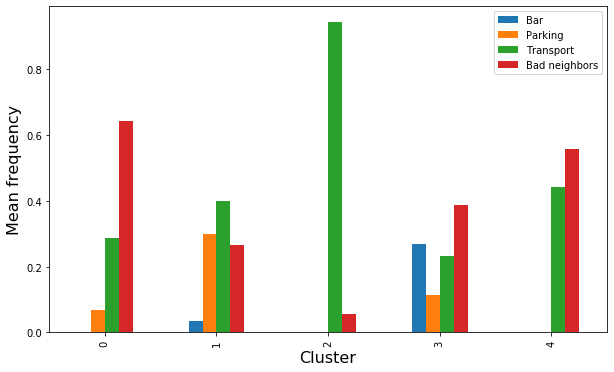

In [520]:
ax_cl = merged[['Cluster', 'Bar', 'Parking', 'Transport', 'Bad neighbors']] \
.groupby('Cluster').mean().plot(kind='bar', figsize=(10,6))
ax_cl.set_ylabel('Mean frequency', fontsize=16)
ax_cl.set_xlabel('Cluster', fontsize=16)
plt.show()

As we see, optimal cluster for us eill be **cluster #3** as there are bars it (other bars nearby is not always a bad thing) and there are acceptable amount of parkings and transport. Also there are not many bad neighbors.

### Compare neighborhoods of chosen cluster

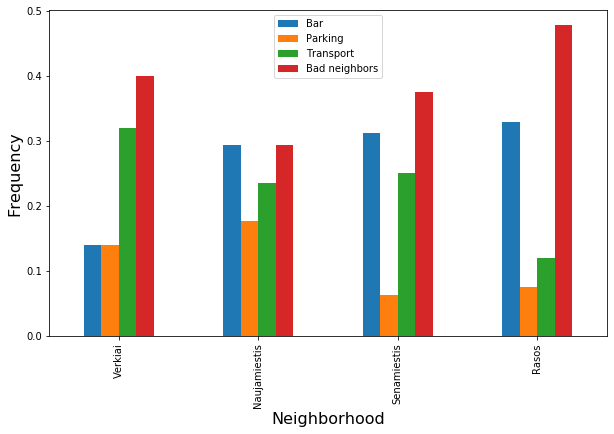

In [516]:
neighborhoods_to_plot = merged[merged['Cluster'] == 3][['Neighborhood', 'Bar', 
                                                        'Parking', 'Transport', 'Bad neighbors']]
ax = neighborhoods_to_plot.plot(kind='bar', figsize=(10,6), x='Neighborhood')
ax.set_xlabel('Neighborhood', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
plt.show()

Out of this 4 neighborhoods, in my opinion, the best will be neighborhood **"Neujamiestis"**, as it has the least number of bad neighbors and a good number of parkings, transport and other bars.

In [529]:
spot = df[df['Neighborhood'] == 'Naujamiestis']
endmap = folium.Map(location=VILNIUS_LOCATION, zoom_start=14)
for (name, lat, lng) in zip(spot['Neighborhood'], spot['Latitude'], spot['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='red',
        fill = True,
        popup=name,
        fill_color='red'
    ).add_to(endmap)
endmap

<img src="img/spot.gif">

## 4. Conclusion
In this project, I mined data on Vilnius neighborhoods and their venues and with the help of k-means cluster algorithm splited neighborhoods into 5 clusters.  
Then, after analysis I chose cluster for our bar and the best neighborhood in it, which is **"Neujamiestis"**.